In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys
import logging
from sklearn import metrics
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.platypus import Table, TableStyle
from reportlab.lib.colors import lavender, red, green
from src import diagnostics 

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
with open('src/config.json','r') as f:
    config = json.load(f) 

prod_deployment_path = os.path.join(config['prod_deployment_path']) 
data_path=os.path.join(config['output_folder_path']) 
test_data_path=os.path.join(config['test_data_path']) 

In [4]:
def plot_confusion_matrix():
    """
    Reporting: calculate a confusion matrix using the test data and the deployed model. Write the confusion matrix to
    the directory specified in the output_model_path entry of the config.json file.
    :return:
    """
    test_data_path = os.path.join(config['test_data_path'], 'testdata.csv')
    test_df = pd.read_csv(test_data_path)
    # true labels for test data
    y_true = test_df.pop('exited')
    X_df = test_df.drop(['corporation'], axis=1)
    logging.info("predicting test data")
    y_pred = diagnostics.model_predictions(X_df)
    confusion = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(confusion, annot=True, cmap='Blues')
    ax.set_title('Confusion matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])
    ax.set_title("Model Confusion Matrix")
    plt.savefig(os.path.join(prod_deployment_path, 'confusionmatrix.png'))
    logging.info(f"confusion matrix saved in {prod_deployment_path}")

In [6]:
def _get_statistics_df():
    """
    Get data statistics and missing percentage of each column
    in pandas dataframe to draw table in the PDF report

    Returns:
        pd.DataFrame: Train data summary
    """
    # Assuming diagnostics.dataframe_summary() and diagnostics.missing_percentage() return dictionaries
    stats = diagnostics.dataframe_summary()  # Returns stats per column (e.g., mean, std, etc.)
    missing = diagnostics.missing_percentage()  # Returns missing percentage per column

    # Create the base dataframe with column names and missing percentages
    columns = ['Column Name', 'Missing %']
    data = {
        'Column Name': [k for k in missing.keys()],
        'Missing %': [missing[column]['percentage'] for column in missing]
    }

    # Now loop through each statistic (e.g., mean, median, std) and add to the dataframe
    temp_col = list(stats.keys())[0]  # Get any column to check the stats structure
    for stat in stats[temp_col].keys():
        data[stat] = [
            round(stats[column].get(stat, None), 2) if stats.get(column) else '-' 
            for column in missing.keys()
        ]

    # Convert the dictionary to DataFrame and return
    df = pd.DataFrame(data)
    return df

In [8]:
def generate_pdf_report(prod_deployment_path, data_path):
    """
    Generate PDF report that includes ingested data information, model scores
    on test data, and diagnostics of execution times and packages.
    """
    # Initialize PDF document
    pdf_filename = os.path.join(prod_deployment_path, 'summary_report.pdf')
    pdf = canvas.Canvas(pdf_filename, pagesize=A4)
    pdf.setTitle("Model Summary Report")

    # Add title to the report
    pdf.setFontSize(24)
    pdf.setFillColorRGB(31 / 256, 56 / 256, 100 / 256)
    pdf.drawCentredString(300, 800, "Model Summary Report")

    # Ingest data section
    pdf.setFontSize(18)
    pdf.setFillColorRGB(47 / 256, 84 / 256, 150 / 256)
    pdf.drawString(25, 750, "Ingested Data")

    pdf.setFontSize(14)
    pdf.setFillColorRGB(46 / 256, 116 / 256, 181 / 256)
    pdf.drawString(35, 725, "List of files used:")

    # Ingested files section (from "ingestedfiles.txt")
    try:
        with open(os.path.join(data_path, "ingestedfiles.txt")) as file:
            pdf.setFontSize(12)
            text = pdf.beginText(40, 705)
            text.setFillColor('black')
            for line in file.readlines():
                text.textLine(line.strip())
            pdf.drawText(text)
    except FileNotFoundError:
        pdf.drawString(35, 705, "Error: 'ingestedfiles.txt' not found.")

    # Data statistics and missing percentage
    data = _get_statistics_df()  # Assuming this is a valid function
    data_df = pd.DataFrame(data)
    data_table = data_df.values.tolist()
    data_table.insert(0, list(data_df.columns))

    # Draw statistics summary table
    stats_table = Table(data_table)
    stats_table.setStyle([
        ('GRID', (0, 0), (-1, -1), 1, 'black'),
        ('BACKGROUND', (0, 0), (-1, 0), lavender)
    ])

    pdf.setFontSize(14)
    pdf.setFillColorRGB(46 / 256, 116 / 256, 181 / 256)
    pdf.drawString(35, 645, "Statistics Summary")
    stats_table.wrapOn(pdf, 40, 520)
    stats_table.drawOn(pdf, 40, 520)

    # Trained model section
    pdf.setFontSize(18)
    pdf.setFillColorRGB(47 / 256, 84 / 256, 150 / 256)
    pdf.drawString(25, 490, "Trained Model Scoring on Test Data")

    pdf.setFontSize(12)
    pdf.setFillColorRGB(128 / 256, 128 / 256, 128 / 256)
    pdf.drawString(25, 480, "testdata.csv")

    # Model score from "latestscore.txt"
    try:
        with open(os.path.join(prod_deployment_path, "latestscore.txt")) as file:
            pdf.setFontSize(12)
            pdf.setFillColor('black')
            pdf.drawString(40, 460, file.read())
    except FileNotFoundError:
        pdf.drawString(40, 460, "Error: 'latestscore.txt' not found.")

    # Model confusion matrix (image)
    try:
        pdf.drawInlineImage(
            os.path.join(prod_deployment_path, 'confusionmatrix.png'),
            40, 150, width=300, height=300)
    except FileNotFoundError:
        pdf.drawString(40, 150, "Error: 'confusionmatrix.png' not found.")

    # New page
    pdf.showPage()

    # Diagnostics section
    pdf.setFontSize(18)
    pdf.setFillColorRGB(47 / 256, 84 / 256, 150 / 256)
    pdf.drawString(25, 780, "Diagnostics")

    # Execution times
    timings = diagnostics.execution_time()

    pdf.setFontSize(14)
    pdf.setFillColorRGB(46 / 256, 116 / 256, 181 / 256)
    pdf.drawString(35, 755, "Execution times:")

    pdf.setFontSize(12)
    text = pdf.beginText(40, 735)
    text.setFillColor('black')

    for time in timings:
        for k, v in time.items():
            text.textLine(f"{k} = {round(v, 4)}")

    pdf.drawText(text)

    # Outdated dependencies table
    data = diagnostics.outdated_packages_list()

    # Ensure data is a DataFrame and convert to list of lists
    if isinstance(data, pd.DataFrame):
        data = data.values.tolist()  # Convert the DataFrame to a list of lists
    else:
        print("Error: Invalid data format for outdated packages.")
        return

    # Style for outdated dependencies table
    table_style = TableStyle()
    table_style.add('GRID', (0, 0), (-1, -1), 1, 'black')
    table_style.add('BACKGROUND', (0, 0), (-1, 0), lavender)

    for row, values in enumerate(data[1:], start=1):  # Start at row 1 to skip header
        if values[1] != values[2]:
            table_style.add('TEXTCOLOR', (1, row), (1, row), red)
            table_style.add('TEXTCOLOR', (2, row), (2, row), green)

    depend_table = Table(data)
    depend_table.setStyle(table_style)

    pdf.setFontSize(14)
    pdf.setFillColorRGB(46 / 256, 116 / 256, 181 / 256)
    pdf.drawString(35, 690, "Outdated Dependencies")
    depend_table.wrapOn(pdf, 40, 325)
    depend_table.drawOn(pdf, 40, 325)

    # Save the PDF
    pdf.save()
    print(f"PDF report generated: {pdf_filename}")


INFO:root:Running reporting.py
INFO:root:Generating confusion matrix
INFO:root:predicting test data
INFO:root:Loading deployed model
INFO:root:Running predictions on data
INFO:root:confusion matrix saved in model/production_deployment
INFO:root:Generating PDF report
INFO:root:Loading and preparing finaldata.csv
INFO:root:Calculating statistics for data
INFO:root:Loading and preparing finaldata.csv
INFO:root:Calculating missing data percentage
INFO:root:Calculating time for ingestion.py


/Users/ruilu/miniconda3/envs/dynamic_risk_assess/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


INFO:root:Calculating time for training.py
INFO:root:Checking outdated dependencies
PDF report generated: model/production_deployment/summary_report.pdf


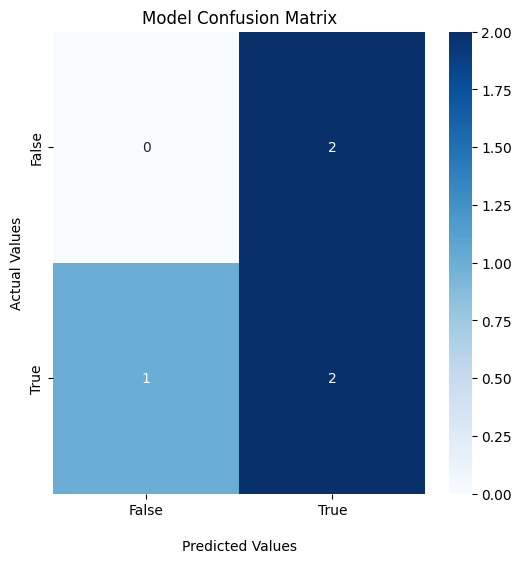

In [10]:
if __name__ == '__main__':
    logging.info("Running reporting.py")

    logging.info("Generating confusion matrix")
    plot_confusion_matrix()

    logging.info("Generating PDF report")
    generate_pdf_report(prod_deployment_path,data_path)